# Exploratory data analysis of DeepDeform

The dataset is from https://github.com/AljazBozic/DeepDeform

## Dataset Structure

A total of 400 sequences.
```
deepdeform
├── train_alignments.json
├── train_masks.json            # Dynamic object annotations for a few frames per sequence
├── train_occlusions.json       # Manually annotated sparse occlusions
├── train_matches.json          # Manually annotated sparse matches
├── train_selfsupervised.json   # Densely aligned optical and scene flow images using self-supervision for a few sequences
├── train
│   ├── seq000                  # <sequence_id>
│   │   ├── color               # color images for every frame (`%06d.jpg`)
│   │   ├── depth               # depth images for every frame (`%06d.png`)
│   │   ├── intrinsics.txt      # 4x4 intrinsics matrix
│   │   ├── mask                # mask images for a few frames (`%06d.png`)
│   │   ├── optical_flow        # optical flow images for a few frame pairs (`<object_id>_<source_id>_<target_id>.oflow`)
│   │   └── scene_flow          # scene flow images for a few frame pairs (`<object_id>_<source_id>_<target_id>.sflow`)
...
├── val
├── val_selfsupervised.json     
├── val_occlusions.json
├── val_matches.json
├── val_masks.json
├── val_alignments.json
├── test
│   ├── seq000
│   │   ├── color
│   │   ├── depth
│   │   └── intrinsics.txt
...
    └── seq029
        ├── color
        ├── depth
        └── intrinsics.txt
```

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
import cv2
import imageio 

from pathlib import Path
from itertools import islice

from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

base_path = "/mnt/raid/kirwul/deepdeform"

In [2]:
# Helper function

space =  '    '
branch = '│   '
tee =    '├── '
last =   '└── '

def tree(dir_path: Path, level: int=-1, limit_to_directories: bool=False,
         length_limit: int=1000):
    """Given a directory Path object print a visual tree structure.
    From: https://stackoverflow.com/questions/9727673/list-directory-tree-structure-in-python
    """
    dir_path = Path(dir_path) # accept string coerceable to Path
    files = 0
    directories = 0
    def inner(dir_path: Path, prefix: str='', level=-1):
        nonlocal files, directories
        if not level: 
            return # 0, stop iterating
        if limit_to_directories:
            contents = [d for d in dir_path.iterdir() if d.is_dir()]
        else: 
            contents = list(dir_path.iterdir())
        pointers = [tee] * (len(contents) - 1) + [last]
        for pointer, path in zip(pointers, contents):
            if path.is_dir():
                yield prefix + pointer + path.name
                directories += 1
                extension = branch if pointer == tee else space 
                yield from inner(path, prefix=prefix+extension, level=level-1)
            elif not limit_to_directories:
                yield prefix + pointer + path.name
                files += 1
    print(dir_path.name)
    iterator = inner(dir_path, level=level)
    for line in islice(iterator, length_limit):
        print(line)
    if next(iterator, None):
        print(f'... length_limit, {length_limit}, reached, counted:')
    print(f'\n{directories} directories' + (f', {files} files' if files else ''))

# The dataset file structure
# tree(Path(base_path), level=3)

## Overview of Some Scenes

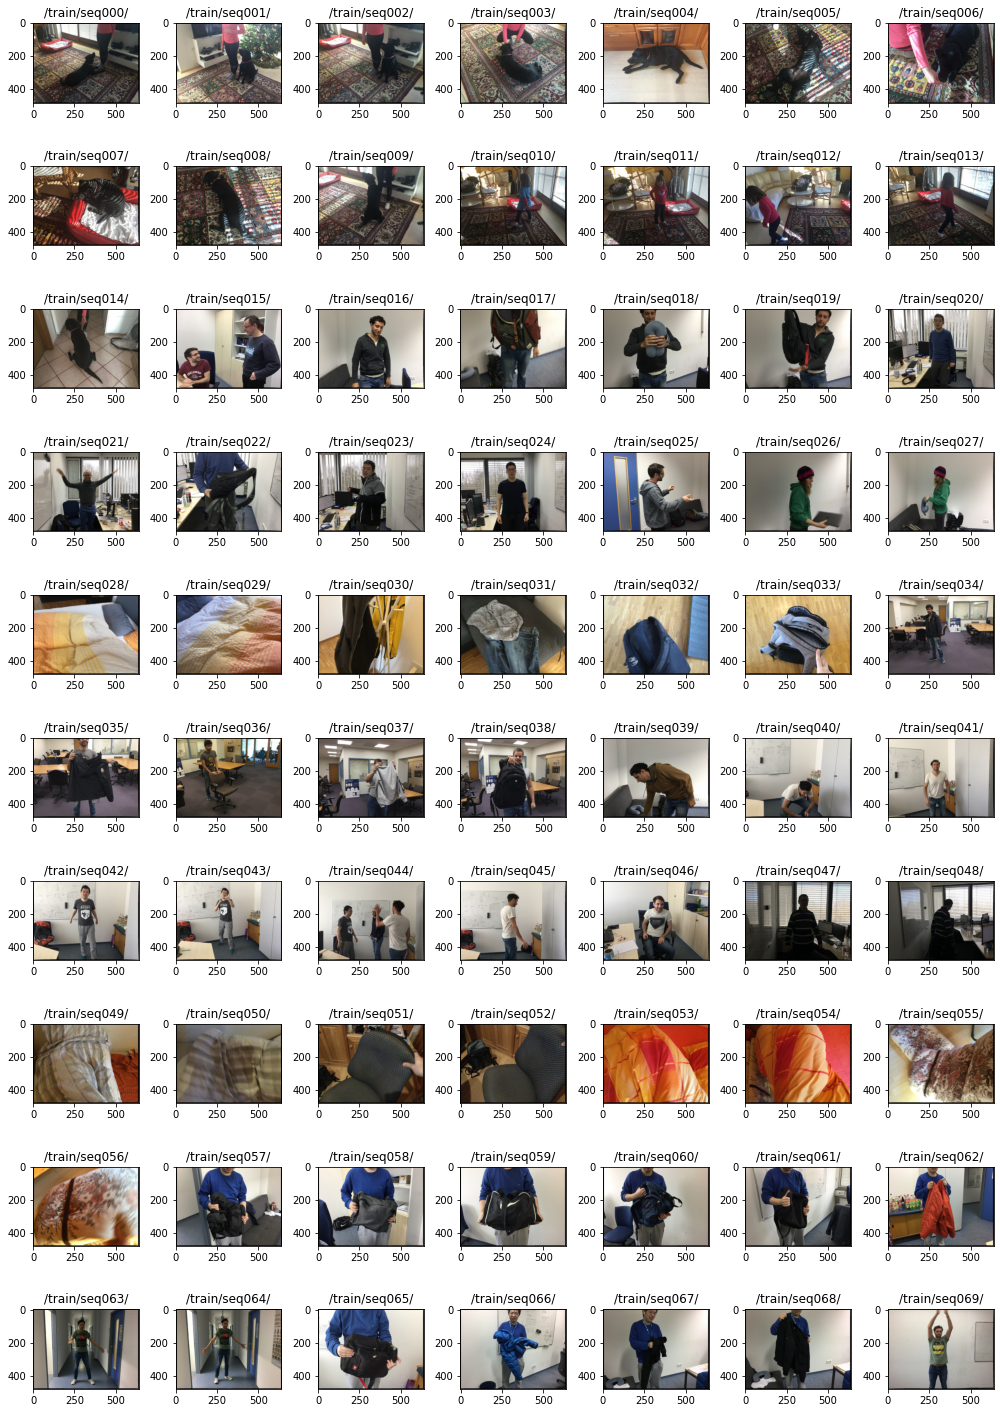

In [3]:
# In the /train set

nrows = 10
ncols = 7
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))
index = 0

for r in range(nrows):
    for c in range(ncols):
        seq = f"/train/seq{''.join(['0' for _ in range(len(str(index)), 3)])}{index}/"

        ax[r, c].imshow(plt.imread(base_path + seq + f"color/000100.jpg"))
        ax[r, c].set_title(seq)
        index += 1

fig.tight_layout()

clear_output()      # Remove this

In [4]:
img_p = base_path + "/train/seq051/"

for i in range(100, 150, 15):
    print(f"000{i}:")
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(plt.imread(img_p + f"color/000{i}.jpg"))
    im = ax[1].imshow(plt.imread(img_p + f"depth/000{i}.png"))
    cax = fig.add_axes([0.95, 0.3, 0.05, 0.4])
    fig.colorbar(im, cax=cax, orientation='vertical')
    plt.show()

clear_output()      # Remove this

## RGB Images

In [5]:
d_img = imageio.imread(img_p + "depth/000000.png")
print("Depth shape:", d_img.shape)
rgb_img = imageio.imread(img_p + "/color/000000.jpg")
print("RGB shape:", rgb_img.shape)
print("D-NeRF RGBA shape:", imageio.imread("./data/lego/train/r_0.png").shape)


Depth shape: (480, 640)
RGB shape: (480, 640, 3)
D-NeRF RGBA shape: (800, 800, 4)


### Takeaways: 
- We do not need to convert our data to RGB! `.png` is RGBA and `.jpg` is RGB.

### Camera Intrinsics

Given in `intrinsics.txt`, e.g. for `seq150`:

$$
K = 
\begin{bmatrix}
    f_x & s & c_x \\
    0 & f_y & c_y \\
    0 & 0 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
    575.666 & 0 & 320.287 \\
    0 & 578.052 & 240.127 \\
    0 & 0 & 1 \\
\end{bmatrix}
$$

where $f_x$ and $f_y$ are the focal lengths in $x$ and $y$ direction respetively, $s$ is a skew parameter and $c_x$ and $c_y$ are the optical center in $x$ and $y$.

Using the equation for the angle of view (from [Wikipedia](https://en.wikipedia.org/wiki/Angle_of_view))

$$\text{AOV}=2 \arctan\left(\frac{\text{sensor size}}{2f}\right)$$

and a 640x480 image size, we compute the horizontal and vertical focal lengths as: `camera_angle_x = ` and `camera_angle_y = `.

The authors used an iPad ([looks like 5th gen.](https://youtu.be/OrHLacCDZVQ?t=99)) to capture RGB images at a resolution of 1296x968 pixels. According to [table 4-23](https://developer.apple.com/library/archive/documentation/DeviceInformation/Reference/iOSDeviceCompatibility/Cameras/Cameras.html) in the Apple Dev docs, the corresponding horizontal FOV is 55.2°. This is at least close to the calculated values.

Fun fact: what is the FOV?
$$\text{FOV}=2 \tan\left(\frac{\text{AOV}}{2}\right)\cdot\text{distance to subject}$$

In [17]:
from load_deepdeform import load_deepdeform_data

images, depth_maps, poses, times, render_poses, render_times, hwf, i_split = load_deepdeform_data("./data/office", True, 1)
print('Loaded deepdeform', images.shape, render_poses.shape, hwf)

Loaded deepdeform (282, 240, 320, 3) torch.Size([10, 4, 4]) [240, 320, 270.3722426470588]


In [ ]:

for i in range(40, 100, 10):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(plt.imread(f"./data/office/train/rgb_0{i}.jpg"))
    #ax[1].imshow(images[i])

clear_output()      # Remove this

The slightly moving background shows that the camera is not actually static.

## Depth data

In [21]:
print(np.min(depth_maps))
print(np.max(depth_maps))

0.0
12.585294723510742


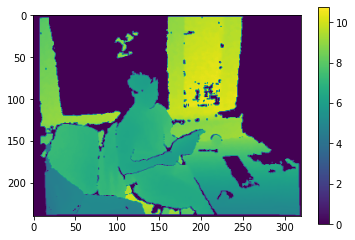

In [22]:
#img_p = base_path + "/train/seq150/"
#img = plt.imread(img_p + f"depth/000000.png")
plt.imshow(depth_maps[0])
plt.colorbar()